## Init

In [127]:
import pandas as pd
import numpy as np
import os
import datetime

from sklearn.experimental import enable_hist_gradient_boosting, enable_iterative_imputer
from sklearn import datasets, linear_model, ensemble, gaussian_process, isotonic, kernel_ridge, neighbors, neural_network, svm, tree
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, max_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold,train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, FunctionTransformer,  StandardScaler, LabelEncoder, LabelBinarizer, RobustScaler
from sklearn.inspection import permutation_importance
import joblib

import lightgbm  
import xgboost 
import catboost
# from keras.wrappers.scikit_learn import KerasRegressor
# from keras.models import Sequential
# from keras.layers import Dense
import optuna

# visualization lib
import matplotlib.pyplot as plt
import seaborn as sns
from rfpimp import permutation_importances, plot_importances, plot_corr_heatmap
# import shap
import eli5
from eli5.sklearn import PermutationImportance

from helper import absolute_score, show_pred, show_feature_importances, reduce_mem_usage

In [128]:
DATASET_NAME = 'on-trade'

DATA_PATH = f'./data/{DATASET_NAME}_pred_data.csv'

MODEL_PATH = f'./models/{DATASET_NAME}_model.joblib'
SCALER_PATH = f'./models/{DATASET_NAME}_scaler.joblib'
IMPUTER_PATH = f'./models/{DATASET_NAME}_imputer.joblib'
SKU_ENCODER_PATH = f'./models/{DATASET_NAME}_sku_encoder.joblib'
BRAND_ENCODER_PATH = f'./models/{DATASET_NAME}_brand_encoder.joblib'

RESULT_CSV_PATH = f'./pred_results/{DATASET_NAME}_pred_result.csv'
RESULT_EXCEL_PATH = f'./pred_results/{DATASET_NAME}_pred_result.xlsx'

MAX_N_JOBS = 8

## Load Model

In [129]:
model = joblib.load(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)
imputer = joblib.load(IMPUTER_PATH)
sku_encoder = joblib.load(SKU_ENCODER_PATH)
brand_encoder = joblib.load(BRAND_ENCODER_PATH)

## Load data

In [130]:
workdays = pd.read_csv(f'./data/workdays.csv', header=0, decimal=",")

workdays = workdays.rename(columns={"Workdays": "NumberWorkdays"})
workdays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Country         626 non-null    object
 1   Year            626 non-null    int64 
 2   Week            626 non-null    int64 
 3   NumberWorkdays  626 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 19.7+ KB


In [131]:
data_dtype = {'SkuShort':'str', 'Brand':'str', 'Country':'str', 'IsLockdown':'bool'} 
data = pd.read_csv(DATA_PATH, header=0, decimal=",", dtype=data_dtype)

data = data.sort_values(by=['Year', 'Week', 'SkuShort', 'Country']).reset_index().drop(columns=['index'])

data.head()

,SkuShort,Brand,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,SalesHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,OldPredSalesHl
0,01000,PILSNER URQUELL,CZ,2021,24,5,22.291209,0.065934,13.250549,False,NaN,NaN,2518.869566,2992.18,2802.21,2679.2198,2437.1216,3275.2201,2878.1678
1,01000,PILSNER URQUELL,SK,2021,24,5,22.291209,0.065934,13.250549,False,NaN,NaN,364.019287,520.00,495.00,455.0000,435.0000,475.0000,369.6183
2,01001,PILSNER URQUELL,CZ,2021,24,5,22.291209,0.065934,13.250549,False,NaN,NaN,NaN,0.30,0.10,NaN,NaN,NaN,1.3500
3,01001,PILSNER URQUELL,SK,2021,24,5,22.291209,0.065934,13.250549,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0000
4,01002,PILSNER URQUELL,CZ,2021,24,5,22.291209,0.065934,13.250549,False,NaN,NaN,688.314709,1212.00,1301.55,1306.5000,887.2500,808.5000,1058.6487


In [132]:
data = helper.reduce_mem_usage(data, ignoreCols=['SalesHl'])

Mem. usage decreased to  0.01 Mb (50.6% reduction)


## Preprocessing

In [133]:
#!!!!!!!!!!!!!!!!!!! WARNING !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

data.PrevWeekSalesHl1 = data.PrevWeekSalesHl2
# data.PrevWeekSalesHl2 = data.PrevWeekSalesHl2

In [134]:
cols_drop = ['SalesHl', 'OldPredSalesHl']
X = data.drop(cols_drop, axis=1)
X_raw = X.copy(deep=True)
y = data.SalesHl.fillna(0).to_numpy()

In [135]:
X['NextWeek'] = X['Week']+1
X['PrevWeek'] = X['Week']-1

X = X.merge(workdays, how='left', left_on=['Country','Year','NextWeek'], right_on=['Country','Year','Week'], suffixes=(None, "Next"))
X = X.merge(workdays, how='left', left_on=['Country','Year','PrevWeek'], right_on=['Country','Year','Week'], suffixes=(None, "Prev"))

X = X.drop(['PrevWeek', 'WeekPrev', 'NextWeek',  'WeekNext'], axis=1)
X['NumberWorkdaysPrev'] = X['NumberWorkdaysPrev'].fillna(5)
X['NumberWorkdaysNext'] = X['NumberWorkdaysNext'].fillna(5)
X

,SkuShort,Brand,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,NumberWorkdaysNext,NumberWorkdaysPrev
0,01000,PILSNER URQUELL,CZ,2021,24,5,22.296875,0.065918,13.25,False,NaN,NaN,2518.000000,2680.0,2680.0,2438.0,3276.000000,5,5
1,01000,PILSNER URQUELL,SK,2021,24,5,22.296875,0.065918,13.25,False,NaN,NaN,364.000000,455.0,455.0,435.0,475.000000,5,5
2,01001,PILSNER URQUELL,CZ,2021,24,5,22.296875,0.065918,13.25,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,5
3,01001,PILSNER URQUELL,SK,2021,24,5,22.296875,0.065918,13.25,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,5
4,01002,PILSNER URQUELL,CZ,2021,24,5,22.296875,0.065918,13.25,False,NaN,NaN,688.500000,1306.0,1306.0,887.0,808.500000,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,15202,KINGSWOOD,CZ,2021,24,5,22.296875,0.065918,13.25,False,NaN,NaN,4.195312,NaN,NaN,NaN,18.359375,5,5
97,17501,VIPER,CZ,2021,24,5,22.296875,0.065918,13.25,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,5
98,20105,SWIST,CZ,2021,24,5,22.296875,0.065918,13.25,False,NaN,NaN,204.250000,134.0,134.0,138.0,259.500000,5,5
99,20205,SWIST,CZ,2021,24,5,22.296875,0.065918,13.25,False,NaN,NaN,669.500000,375.0,375.0,320.5,835.000000,5,5


In [136]:
Country_mapping = {"CZ": 1, "SK": 2}

X.Country = X.Country.map(Country_mapping)

X.SkuShort = sku_encoder.transform(X.SkuShort)
X.Brand = brand_encoder.transform(X.Brand)

X.head()

,SkuShort,Brand,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,NumberWorkdaysNext,NumberWorkdaysPrev
0,0,10,1,2021,24,5,22.296875,0.065918,13.25,False,NaN,NaN,2518.0,2680.0,2680.0,2438.0,3276.0,5,5
1,0,10,2,2021,24,5,22.296875,0.065918,13.25,False,NaN,NaN,364.0,455.0,455.0,435.0,475.0,5,5
2,1,10,1,2021,24,5,22.296875,0.065918,13.25,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,5
3,1,10,2,2021,24,5,22.296875,0.065918,13.25,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,5
4,2,10,1,2021,24,5,22.296875,0.065918,13.25,False,NaN,NaN,688.5,1306.0,1306.0,887.0,808.5,5,5


In [137]:
X.BgtHl = X.BgtHl.fillna(0)
X.PdtHl = X.PdtHl.fillna(0)
X.PrevWeekPdtHl1 = X.PrevWeekPdtHl1.fillna(0)

In [138]:
X = pd.DataFrame(imputer.transform(X), columns=X.columns)
X

,SkuShort,Brand,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,NumberWorkdaysNext,NumberWorkdaysPrev
0,0.0,10.0,1.0,2021.0,24.0,5.0,22.296875,0.065918,13.25,0.0,0.0,0.0,2518.000000,2680.000000,2680.000000,2438.000000,3276.000000,5.0,5.0
1,0.0,10.0,2.0,2021.0,24.0,5.0,22.296875,0.065918,13.25,0.0,0.0,0.0,364.000000,455.000000,455.000000,435.000000,475.000000,5.0,5.0
2,1.0,10.0,1.0,2021.0,24.0,5.0,22.296875,0.065918,13.25,0.0,0.0,0.0,0.000000,649.619645,650.752694,709.045507,749.326224,5.0,5.0
3,1.0,10.0,2.0,2021.0,24.0,5.0,22.296875,0.065918,13.25,0.0,0.0,0.0,0.000000,649.619645,650.752694,709.045507,749.326224,5.0,5.0
4,2.0,10.0,1.0,2021.0,24.0,5.0,22.296875,0.065918,13.25,0.0,0.0,0.0,688.500000,1306.000000,1306.000000,887.000000,808.500000,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,117.0,6.0,1.0,2021.0,24.0,5.0,22.296875,0.065918,13.25,0.0,0.0,0.0,4.195312,649.619645,650.752694,709.045507,18.359375,5.0,5.0
97,120.0,16.0,1.0,2021.0,24.0,5.0,22.296875,0.065918,13.25,0.0,0.0,0.0,0.000000,649.619645,650.752694,709.045507,749.326224,5.0,5.0
98,121.0,14.0,1.0,2021.0,24.0,5.0,22.296875,0.065918,13.25,0.0,0.0,0.0,204.250000,134.000000,134.000000,138.000000,259.500000,5.0,5.0
99,122.0,14.0,1.0,2021.0,24.0,5.0,22.296875,0.065918,13.25,0.0,0.0,0.0,669.500000,375.000000,375.000000,320.500000,835.000000,5.0,5.0


In [139]:
#Avg 
X['AvgPrevWeekSalesHl'] = X[['PrevWeekSalesHl1', 'PrevWeekSalesHl2']].mean(axis=1).round(1)
X['AvgPrevYearSalesHl'] = X[['PrevYearSalesHl1', 'PrevYearSalesHl2']].mean(axis=1).round(1)
X['AvgPrevAllSalesHl'] = X[['PrevYearSalesHl1', 'PrevYearSalesHl2', 'PrevWeekSalesHl1', 'PrevWeekSalesHl2']].mean(axis=1).round(1)

X

,SkuShort,Brand,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,...,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,NumberWorkdaysNext,NumberWorkdaysPrev,AvgPrevWeekSalesHl,AvgPrevYearSalesHl,AvgPrevAllSalesHl
0,0.0,10.0,1.0,2021.0,24.0,5.0,22.296875,0.065918,13.25,0.0,...,2518.000000,2680.000000,2680.000000,2438.000000,3276.000000,5.0,5.0,2680.0,2857.0,2768.5
1,0.0,10.0,2.0,2021.0,24.0,5.0,22.296875,0.065918,13.25,0.0,...,364.000000,455.000000,455.000000,435.000000,475.000000,5.0,5.0,455.0,455.0,455.0
2,1.0,10.0,1.0,2021.0,24.0,5.0,22.296875,0.065918,13.25,0.0,...,0.000000,649.619645,650.752694,709.045507,749.326224,5.0,5.0,650.2,729.2,689.7
3,1.0,10.0,2.0,2021.0,24.0,5.0,22.296875,0.065918,13.25,0.0,...,0.000000,649.619645,650.752694,709.045507,749.326224,5.0,5.0,650.2,729.2,689.7
4,2.0,10.0,1.0,2021.0,24.0,5.0,22.296875,0.065918,13.25,0.0,...,688.500000,1306.000000,1306.000000,887.000000,808.500000,5.0,5.0,1306.0,847.8,1076.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,117.0,6.0,1.0,2021.0,24.0,5.0,22.296875,0.065918,13.25,0.0,...,4.195312,649.619645,650.752694,709.045507,18.359375,5.0,5.0,650.2,363.7,506.9
97,120.0,16.0,1.0,2021.0,24.0,5.0,22.296875,0.065918,13.25,0.0,...,0.000000,649.619645,650.752694,709.045507,749.326224,5.0,5.0,650.2,729.2,689.7
98,121.0,14.0,1.0,2021.0,24.0,5.0,22.296875,0.065918,13.25,0.0,...,204.250000,134.000000,134.000000,138.000000,259.500000,5.0,5.0,134.0,198.8,166.4
99,122.0,14.0,1.0,2021.0,24.0,5.0,22.296875,0.065918,13.25,0.0,...,669.500000,375.000000,375.000000,320.500000,835.000000,5.0,5.0,375.0,577.8,476.4


In [140]:
X = pd.DataFrame(scaler.transform(X), columns=X.columns)

## Predict

In [141]:
y_pred = model.predict(X)
y_pred[y_pred < 0] = 0
y_pred = y_pred.round(0)

In [142]:
print(DATASET_NAME)
print('----------------')
print('Coefficient of determination: %.4f'% r2_score(y, y_pred))
print('Absolute Score: %.4f'% absolute_score(y, y_pred))
print('Mean absolute error regression loss.: %.4f'% mean_absolute_error(y, y_pred))
print('Maximum residual error: %.4f'% max_error(y, y_pred))
print('Mean squared error regression loss: %.4f'% mean_squared_error(y, y_pred))

on-trade
----------------
Coefficient of determination: 0.9896
Absolute Score: 0.8912
Mean absolute error regression loss.: 89.8274
Maximum residual error: 1045.5000
Mean squared error regression loss: 37672.7436


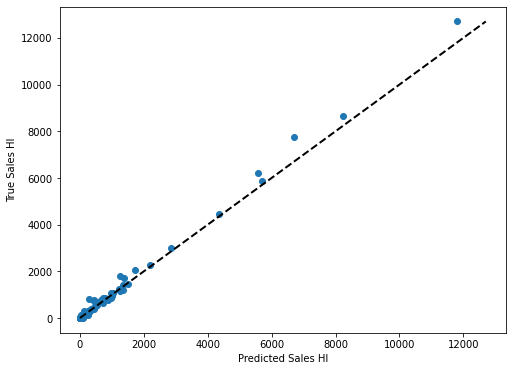

In [143]:
show_pred(y, y_pred, "Predicted Sales Hl", "True Sales Hl")

## Save Result 

In [144]:
result = X_raw.copy(deep=True)
result["TrueSalesHl"] = y
result["PredSalesHl_ML"] = y_pred

dir_path = os.path.dirname(RESULT_CSV_PATH)
if (not os.path.isdir(dir_path)):
    os.mkdir(dir_path)
 
result.to_csv(RESULT_CSV_PATH, index=False)
result.to_excel(RESULT_EXCEL_PATH, index=False)